In [88]:
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf


In [89]:
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (18,10)

In [90]:
kld = pd.read_csv('../data/processed/kolding_features.csv', index_col='Datetime', parse_dates=['Datetime'])
kld.head()

,Value,sunshine_mins,airtemp_c,humidity_pct,windspeed_mps,precip_mins,precip_mm,daylength_hrs
Datetime,,,,,,,,
2019-01-01 00:00:00,116.322,0.0,7.850000,87.833333,11.716667,0.0,0.0,7.148307
2019-01-01 01:00:00,102.681,0.0,7.883333,88.500000,11.983333,0.0,0.0,7.148307
2019-01-01 02:00:00,96.379,0.0,7.850000,91.500000,11.183333,0.0,0.0,7.148307
2019-01-01 03:00:00,85.352,0.0,7.983333,93.500000,10.516667,0.0,0.0,7.148307
2019-01-01 04:00:00,74.842,0.0,8.166667,83.333333,12.666667,1.0,0.1,7.148307


In [91]:
kld.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19128 entries, 2019-01-01 00:00:00 to 2021-03-07 23:00:00
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Value          19128 non-null  float64
 1   sunshine_mins  19128 non-null  float64
 2   airtemp_c      19128 non-null  float64
 3   humidity_pct   19128 non-null  float64
 4   windspeed_mps  19128 non-null  float64
 5   precip_mins    19128 non-null  float64
 6   precip_mm      19128 non-null  float64
 7   daylength_hrs  19128 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


In [92]:
# Processing Parameters
split = 0.80 # split percentage for training data
train_split = int(split * kld.shape[0]) # idx for training split
val_split = int((split+0.1) * kld.shape[0]) #idx for val split
steps = 1 # timesteps: 1 hour

lookback = 24 * 7 # the number of hours in the past the model is shown
horizon = 1 # the target hour in the future we want to predict 1 hour ahead

# Training parameters
batch_size = 256
epochs = 50
lr = 0.001

In [93]:
# Feature selection
kld.corr()

,Value,sunshine_mins,airtemp_c,humidity_pct,windspeed_mps,precip_mins,precip_mm,daylength_hrs
Value,1.000000,-0.217307,-0.468430,0.191755,0.134098,0.061115,0.042695,-0.524148
sunshine_mins,-0.217307,1.000000,0.350167,-0.613523,-0.120503,-0.123432,-0.098074,0.309418
airtemp_c,-0.468430,0.350167,1.000000,-0.338781,-0.093213,-0.003332,0.022778,0.710139
humidity_pct,0.191755,-0.613523,-0.338781,1.000000,-0.001326,0.192857,0.151325,-0.421105
windspeed_mps,0.134098,-0.120503,-0.093213,-0.001326,1.000000,0.186875,0.147137,-0.225790
precip_mins,0.061115,-0.123432,-0.003332,0.192857,0.186875,1.000000,0.897810,-0.047677
precip_mm,0.042695,-0.098074,0.022778,0.151325,0.147137,0.897810,1.000000,-0.018707
daylength_hrs,-0.524148,0.309418,0.710139,-0.421105,-0.225790,-0.047677,-0.018707,1.000000


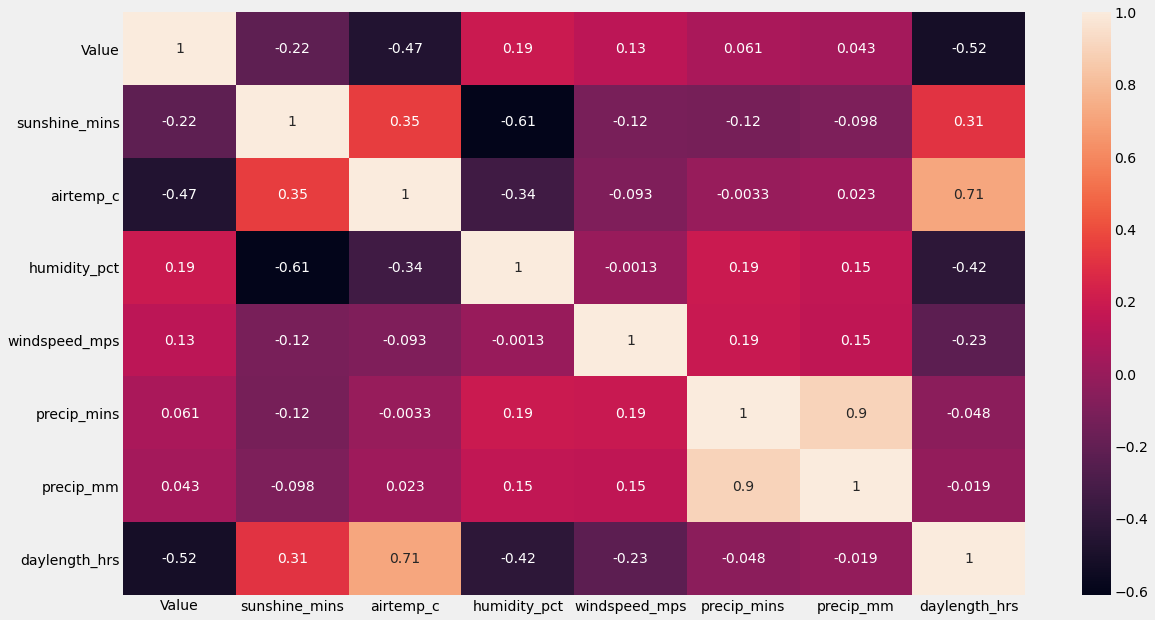

In [94]:
import seaborn as sns

sns.heatmap(kld.corr(), annot=True)
plt.show()

In [95]:
# For now I use all for experiments

train = kld.iloc[:train_split]
val = kld.iloc[train_split:val_split]
test = kld.iloc[val_split:]

In [96]:
print(train.shape, val.shape, test.shape)

(15302, 8) (1913, 8) (1913, 8)


### Training Dataset

In [97]:
# Determine starting point for training set
start = lookback+horizon
end = start+train_split

# Make supervised
X_train = train.values
y_train = kld.iloc[start:end][['Value']]

In [98]:
# Scale Training Data
X_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train = X_scaler.fit_transform(X_train)
y_train = y_scaler.fit_transform(y_train)

In [99]:
# Now I use keras preprocessing tool to create batches for inputs using the timeseries_dataset_from_array() function
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
sequence_length = int(lookback/steps)

In [100]:
dataset_train = timeseries_dataset_from_array(
    X_train, y_train,
    sequence_length=sequence_length,
    sampling_rate=steps,
    batch_size=batch_size
)


### Validation Dataset

In [101]:
x_end = len(val) - lookback - horizon

y_val_start = train_split + lookback + horizon


X_val = val.iloc[:x_end]
y_val = kld.iloc[y_val_start:y_val_start+x_end][['Value']]

In [102]:
X_val = X_scaler.transform(X_val)
y_val = y_scaler.transform(y_val)

In [103]:
dataset_val = timeseries_dataset_from_array(
    X_val, y_val,
    sequence_length=sequence_length,
    sampling_rate=steps,
    batch_size=batch_size
)

### Test Dataset

In [104]:
x_end = len(test) - lookback - horizon
y_test_start = val_split + lookback + horizon

X_test = test.iloc[:x_end]
y_test = kld.iloc[y_test_start:y_test_start+x_end][['Value']]

In [105]:
X_test = X_scaler.transform(X_test)
y_test = y_scaler.transform(y_test)

In [106]:
dataset_test = timeseries_dataset_from_array(
    X_test, y_test,
    sequence_length=sequence_length,
    sampling_rate=steps,
    batch_size=batch_size
)

### Testing Batch Maker

In [107]:
for batch in dataset_train.take(1):
    inputs, targets = batch
    
print(f"Input Shape: {inputs.numpy().shape}")
print(f"Target Shape: {targets.numpy().shape}")

Input Shape: (256, 168, 8)
Target Shape: (256, 1)


The model will now see a batch size of 256 with 168 timesteps in the past of 7 features. The target will be the one load value of a batch size 256.

### Set-up Model and Training

In [108]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [109]:
model = Sequential()

model.add(LSTM(64, input_shape=(inputs.shape[1], inputs.shape[2])))
model.add(Dense(1))

model.compile(optimizer=Adam(learning_rate=lr), loss="mse")

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                18688     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 18,753
Trainable params: 18,753
Non-trainable params: 0
_________________________________________________________________


In [110]:
# Callbacks
ckpt_path = "../model/test_model.h5"
estp = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

ckpt = ModelCheckpoint(
    monitor='val_loss',
    filepath=ckpt_path,
    verbose=1,
    save_weights_only=True,
    save_best_only=True
)

In [111]:
history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[estp, ckpt]
)

Epoch 1/50
60/60 [==============================] - 13s 186ms/step - loss: 1.0303 - val_loss: 1.0207

Epoch 00001: val_loss improved from inf to 1.02069, saving model to ../model\test_model.h5
Epoch 2/50
60/60 [==============================] - 11s 175ms/step - loss: 0.7043 - val_loss: 0.7266

Epoch 00002: val_loss improved from 1.02069 to 0.72660, saving model to ../model\test_model.h5
Epoch 3/50
60/60 [==============================] - 10s 172ms/step - loss: 0.5603 - val_loss: 0.5293

Epoch 00003: val_loss improved from 0.72660 to 0.52926, saving model to ../model\test_model.h5
Epoch 4/50
60/60 [==============================] - 10s 174ms/step - loss: 0.4317 - val_loss: 1.3929

Epoch 00004: val_loss did not improve from 0.52926
Epoch 5/50
60/60 [==============================] - 11s 178ms/step - loss: 0.7453 - val_loss: 0.4842

Epoch 00005: val_loss improved from 0.52926 to 0.48419, saving model to ../model\test_model.h5
Epoch 6/50
60/60 [==============================] - 10s 174ms/s

### Training Performance

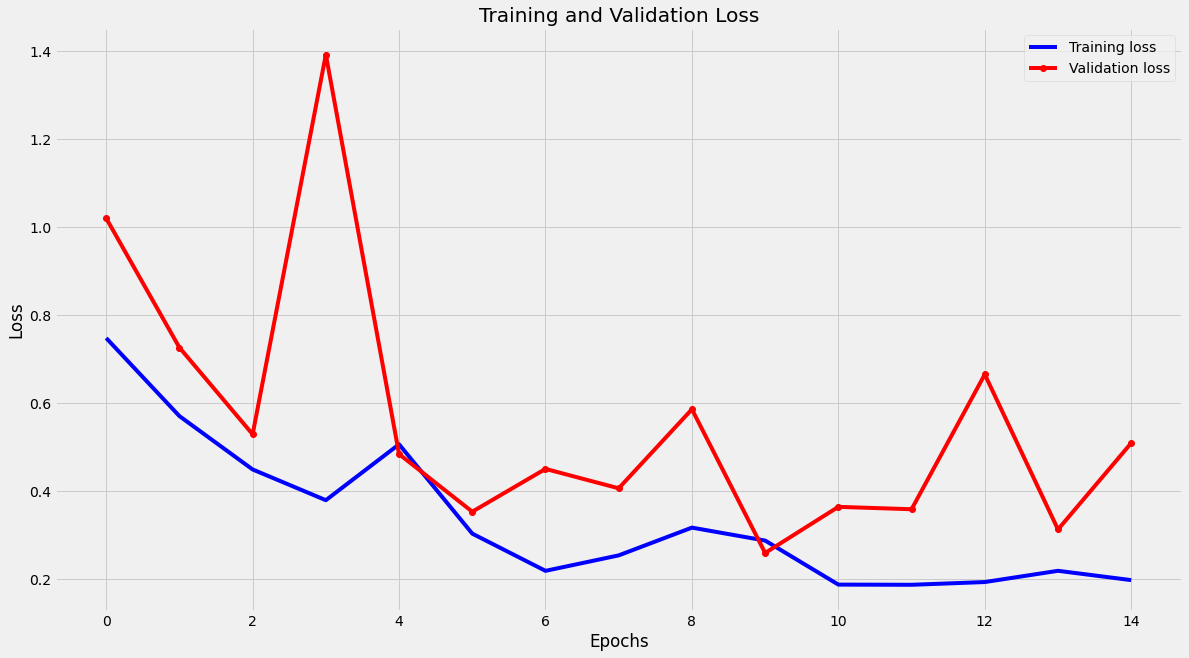

In [112]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "ro-", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")


### Predictions

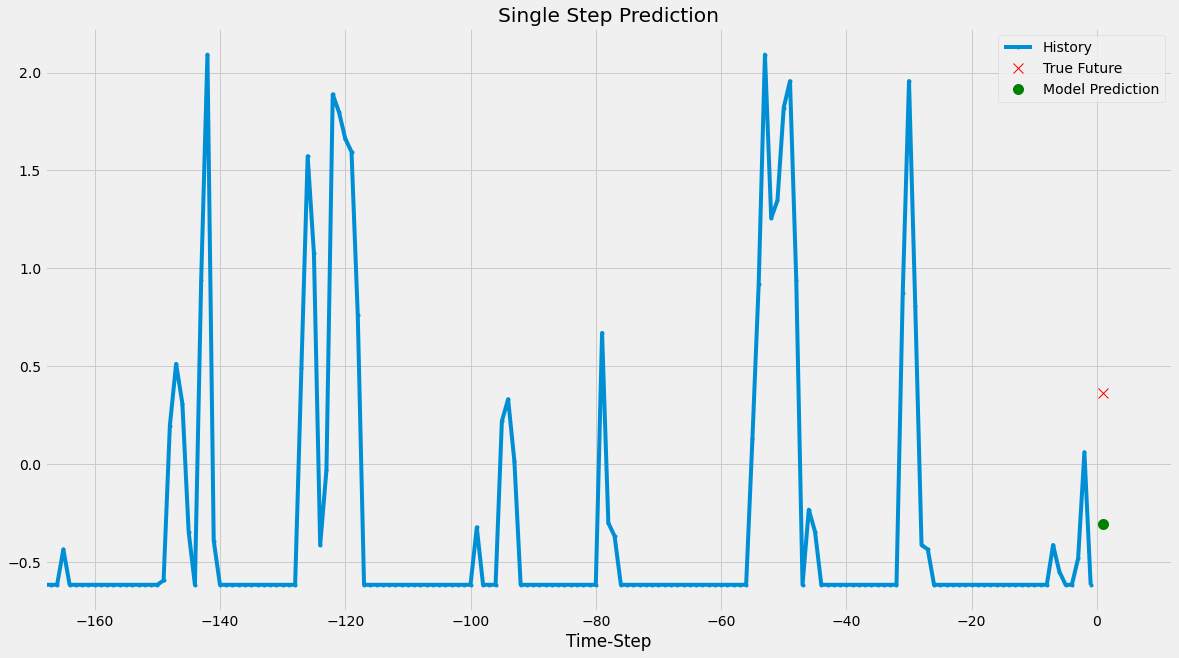

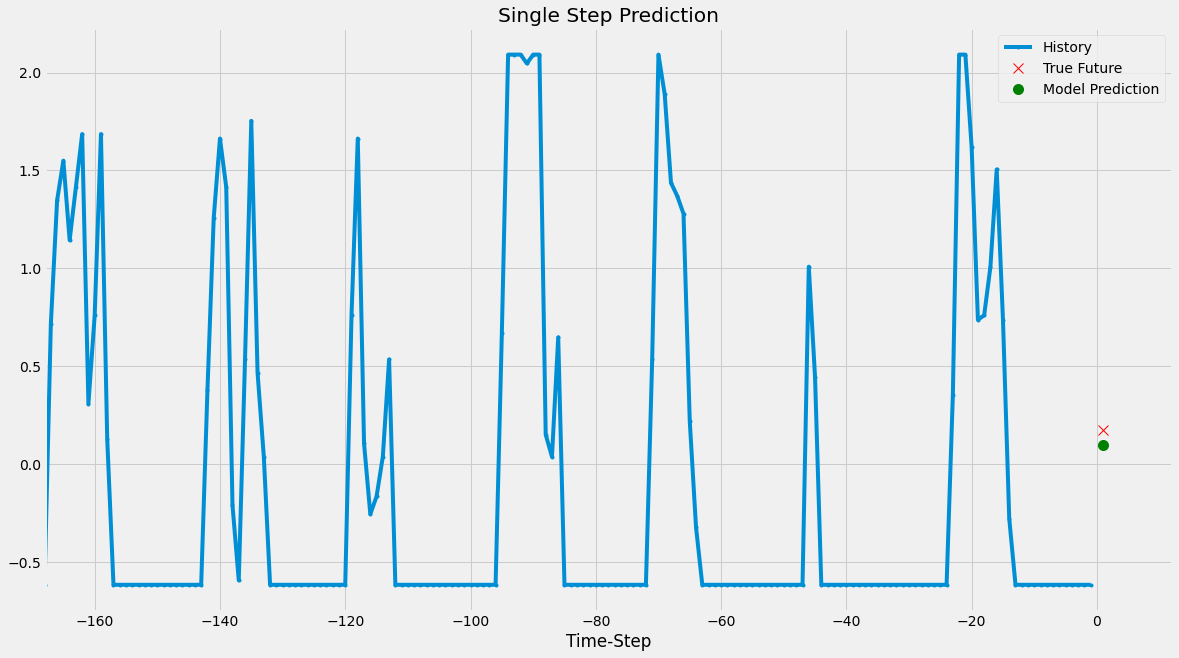

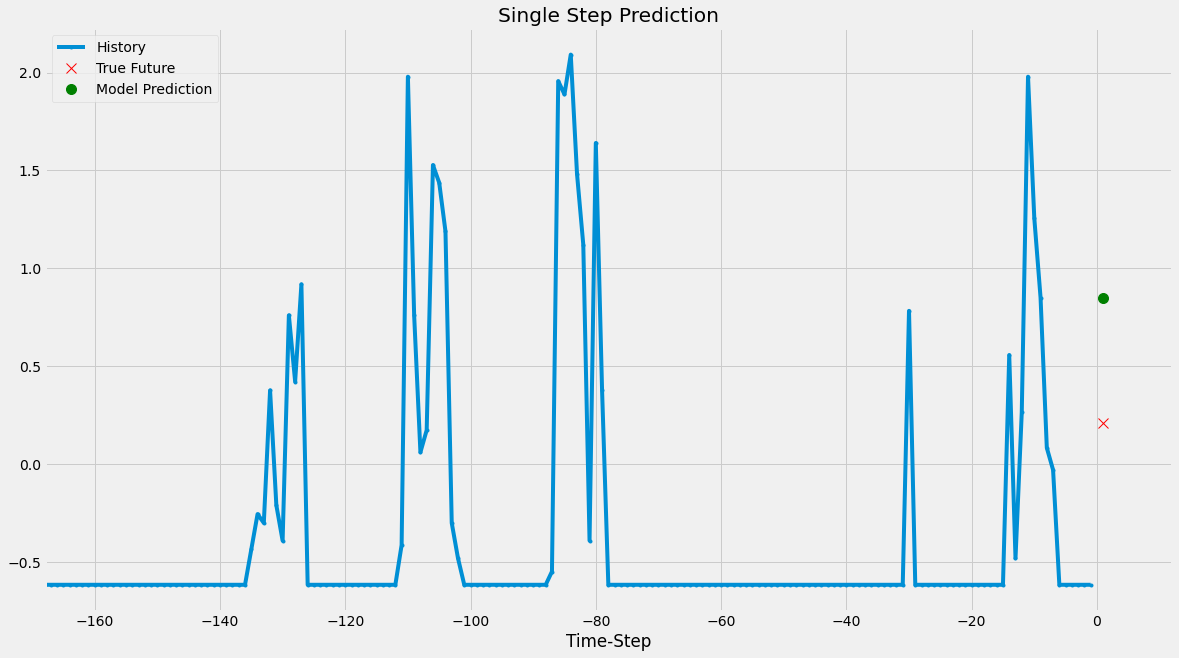

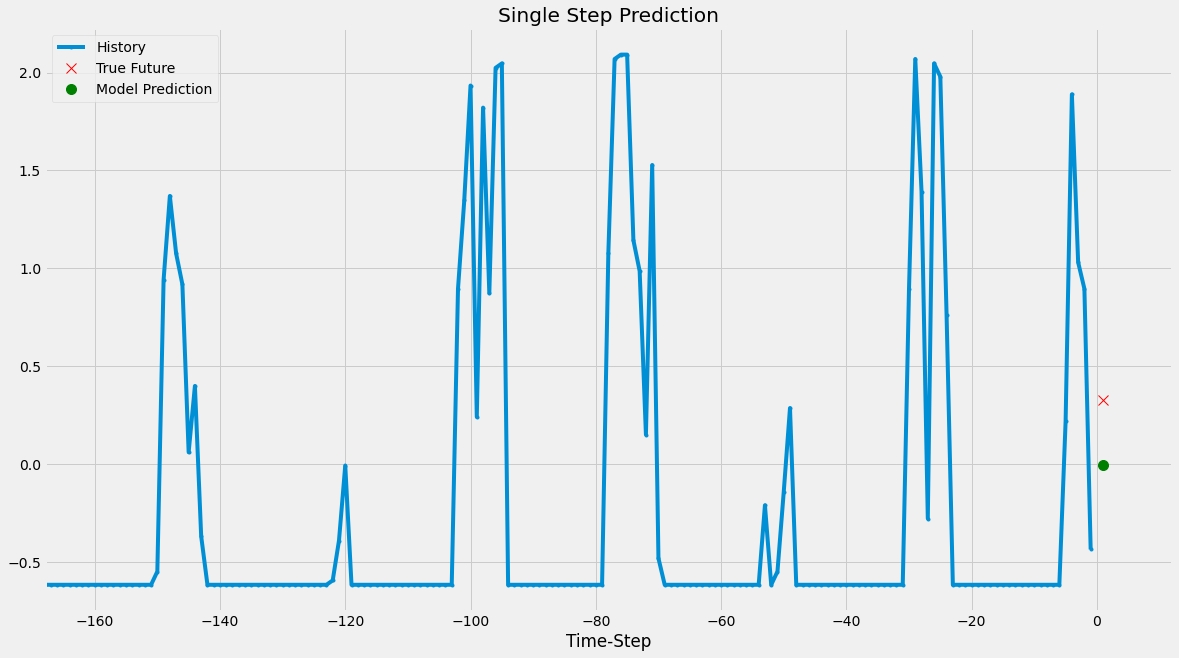

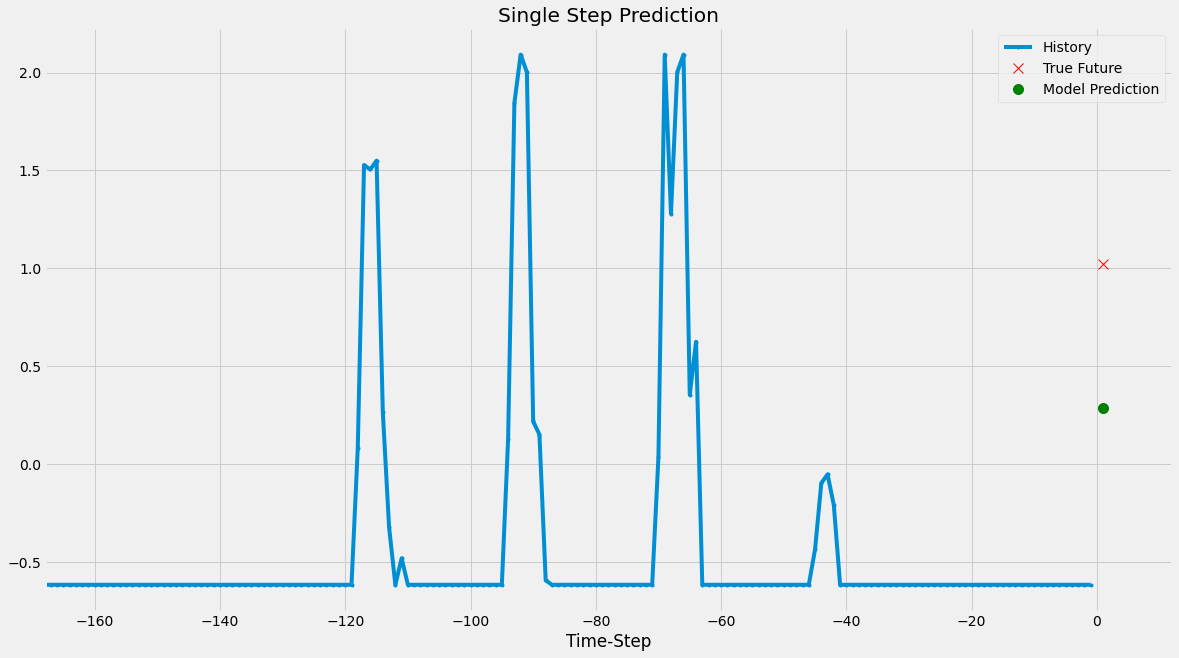

In [113]:
def show_plot(plot_data, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(horizon, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (horizon + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        "Single Step Prediction",
    )


In [114]:
model.evaluate(dataset_test)

7/7 [==============================] - 1s 92ms/step - loss: 0.6421


0.6421430706977844